### Tentative Plan

• Decide on how to break down categorical variables  -DONE 5/17<br> 
    • Convert categorical variables to dummy variables -DONE 5/17<br>
• Linear regression for valuation <br>
• Test for hidden counfounders? <br>
• Refit without large p-values or fit lasso regression for better model <br>
• Create labels for companies based on valuation size -DONE 5/18<br>
• Use logistic regression to classify based on labels -DONE 5/18<br>
• Decide on which funding series to use for funding amounts  https://support.crunchbase.com/hc/en-us/articles/115010458467-Glossary-of-Funding-Types <br>
• Split data into different models for each series <br>
• Run linear regression to see what factors are most important for funding amount at each series

### Imports

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from scipy.stats import mode
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier

### Loading data

In [2]:
#accessing data via github
url1 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/acquisitions.csv"
download1 = requests.get(url1).content
url2 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/degrees.csv"
download2 = requests.get(url2).content
url3 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/funding_rounds.csv"
download3 = requests.get(url3).content
url4 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/funds.csv"
download4 = requests.get(url4).content
url5 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/investments.csv"
download5 = requests.get(url5).content
url6 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/ipos.csv"
download6 = requests.get(url6).content
url7 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/offices.csv"
download7 = requests.get(url7).content
url8 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/people.csv"
download8 = requests.get(url8).content
url9 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/relationships.csv"
download9 = requests.get(url9).content

#load in the data
acqs = pd.read_csv(io.StringIO(download1.decode('utf-8')))
degs = pd.read_csv(io.StringIO(download2.decode('utf-8')))
rounds = pd.read_csv(io.StringIO(download3.decode('utf-8')))
funds = pd.read_csv(io.StringIO(download4.decode('utf-8')))
invs = pd.read_csv(io.StringIO(download5.decode('utf-8')))
ipos = pd.read_csv(io.StringIO(download6.decode('utf-8')))
ofcs = pd.read_csv(io.StringIO(download7.decode('utf-8')))
ppl = pd.read_csv(io.StringIO(download8.decode('utf-8')))
relns = pd.read_csv(io.StringIO(download9.decode('utf-8')))


#too large for github....may need to use git lfs
objs = pd.read_csv('/Users/kirk.hachigian/Desktop/21SpringClasses/3120/Project/objects.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Outcome variable (valuation at IPO/acquisition)

In [3]:
#response variable for each company = ipo valuation or acquisition price
Y1 = objs.merge(acqs,left_on='id',right_on='acquired_object_id')
Y1 = Y1[['id_x','name','price_amount']]
#Y1 = Y1[Y1['price_amount']!=0.0]
Y1.columns = ['id','name','valuation']

Y2 = objs.merge(ipos,left_on='id',right_on='object_id')
Y2 = Y2[['id_x','name','valuation_amount']]
Y2 = Y2[Y2['valuation_amount']!=0.0]
Y2.columns = ['id','name','valuation']

Y = Y1.append(Y2)
Y.reset_index(inplace=True, drop=True)

### Predictor dataframe

In [4]:
#create df listing person id, name, company id, title, degree type, subject, institution only 
#for companies in response
df1 = ppl.merge(degs, on='object_id')
df3 = df1[['object_id','first_name','last_name','degree_type','subject','institution']]
df4 = df3.merge(relns, left_on='object_id',right_on='person_object_id')
df5 = df4[['person_object_id','first_name','last_name','relationship_object_id','title','degree_type','subject','institution']]
df5.columns=['person_id','first_name','last_name','company_id','title','degree_type','degree_subject','institution']
df6 = df5[df5['company_id'].isin(list(Y['id']))]
df6.reset_index(inplace=True, drop=True)

In [5]:
#group by company to find the most common degree type, subject, and institution at each company
df66 = df6.dropna(axis=0,how='any')
df6f = df66.groupby(by=['company_id']).agg(lambda x: mode(x)[0])
df6f.reset_index(inplace=True)

In [6]:
#create df listing company id, name, category, country, state, city, funding round, total funding amount only
#for companies in the response Y
dfa = objs[objs['entity_type']=='Company']
dfa = dfa[['id','name','category_code','country_code','state_code','city','funding_rounds','funding_total_usd']]
dfb = dfa[dfa['id'].isin(list(Y['id']))]
dfb.reset_index(inplace=True, drop=True)

### Dataframe with predictors and response

In [7]:
#merge predictor dataframes on company id with valuation as the outcome variable
Y = Y.merge(df6f,left_on='id',right_on='company_id')
Y = Y.merge(dfb,on='id')
Yf = Y[['id','degree_type','degree_subject','institution','category_code', 'state_code', 'funding_rounds','funding_total_usd','valuation']]
Yf = Yf.dropna(axis=0,how='any')
Yf.reset_index(inplace=True,drop=True)
Yf.columns=['company_id','most_common_degree_type','most_common_degree_subject','most_common_institution','category','state','funding_rounds','total_funding','valuation']
Yf



,company_id,most_common_degree_type,most_common_degree_subject,most_common_institution,category,state,funding_rounds,total_funding,valuation
0,c:10,BA,Compute Science,University of Michigan,games_video,CA,0,0.0,2.000000e+07
1,c:100,BS,Computer Science,Stanford University,games_video,CA,0,0.0,0.000000e+00
2,c:1001,MS,Computer Science,Stanford University,web,CA,1,5000000.0,4.750000e+07
3,c:10014,BS,Communications,Lancaster University,mobile,CA,1,0.0,0.000000e+00
4,c:1004,BA,Political Science,University of Michigan,games_video,WA,0,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...
2586,c:65680,BS,Biochemistry,University of Missouri-Columbia,biotech,KS,4,76750000.0,2.230000e+08
2587,c:71350,BS,Computer Science,Columbia University,messaging,MA,0,0.0,2.000000e+07
2588,c:757,BS,Computer Science,Stanford University,software,CA,5,69426794.0,1.000000e+09
2589,c:8530,BA,BA,Columbia University,software,PA,1,12500000.0,1.000000e+09


### Creating dummy variables for categorical predictors

In [8]:
pd.set_option("display.max_rows",2000)

In [9]:
#dummy variables for degree type: BS/BE, BA, BBA, Graduate (MS, MBA, PhD, JD), Other
Yf['most_common_degree_type'] = Yf['most_common_degree_type'].replace(['BS','BE'],'Undergraduate Science')
Yf['most_common_degree_type'] = Yf['most_common_degree_type'].replace('BA','Undergraduate Arts')
Yf['most_common_degree_type'] = Yf['most_common_degree_type'].replace('BBA','Undergraduate Business')
Yf['most_common_degree_type'] = Yf['most_common_degree_type'].replace(['MS','PhD','MBA','JD'],'Graduate')
for degree in Yf['most_common_degree_type'].unique():
    if degree not in ['Undergraduate Science','Graduate','Undergraduate Business','Undergraduate Arts']:
        Yf['most_common_degree_type'] = Yf['most_common_degree_type'].replace(degree,'Other')
        
Yf['most_common_degree_type'].value_counts()        

Undergraduate Science     1258
Undergraduate Arts         884
Graduate                   217
Other                      176
Undergraduate Business      56
Name: most_common_degree_type, dtype: int64

#### TODO: try to figure out the regex using replace

In [10]:
#dummy variables for degree subjects:
#computer science, ece, meche, other engineering, business, accounting/finance, biology/chemistry/physics, english/comm/history/psych, other
Yf['most_common_degree_subject'] = Yf['most_common_degree_subject'].replace(['Computer Engineering','Computer Information Systems','Computer Science & Engineering'],'Computer Science')
Yf['most_common_degree_subject'] = Yf['most_common_degree_subject'].replace(['Engineering','Chemical Engineering','Aerospace Engineering','Mathematics','Applied Mathematics','Industrial Engineering'],'Other Engineering')
Yf['most_common_degree_subject'] = Yf['most_common_degree_subject'].replace(['Business','MBA','Marketing','Business Managment','Entreprneurship','Business Administration'],'Business/Management')
Yf['most_common_degree_subject'] = Yf['most_common_degree_subject'].replace(['Accounting','Finance'],'Accounting/Finance')
Yf['most_common_degree_subject'] = Yf['most_common_degree_subject'].replace(['Biology','Chemistry','Biochemistry','Physics','Applied Physics'],'Physical Sciences')
Yf['most_common_degree_subject'] = Yf['most_common_degree_subject'].replace(['Economics','Law','Political Science','Communications','English','History','Psychology','Anthropology','Cognitive Science','Philosophy'],'Social Sciences')

for degree in Yf['most_common_degree_subject'].unique():
    if degree not in ['Computer Science','Business/Managment','Social Sciences','Electrical Engineering','Accounting/Finance','Other Engineering','Physical Sciences','Mechanical Engineering']:
        Yf['most_common_degree_subject'] = Yf['most_common_degree_subject'].replace(degree,'Other')

Yf['most_common_degree_subject'].value_counts()


Other                     1181
Computer Science           519
Social Sciences            266
Electrical Engineering     197
Accounting/Finance         163
Other Engineering          110
Physical Sciences          109
Mechanical Engineering      46
Name: most_common_degree_subject, dtype: int64

In [11]:
#dummy variables for institutions – should note that ranking from 2021 and more institutions 
# than 10 per tier due to ties in the ranking (https://www.usnews.com/best-colleges/rankings/national-universities):

Yf['most_common_institution'] = Yf['most_common_institution'].replace(['Harvard University','Harvard Business School','Stanford University','Stanford University Graduate School of Business','Massachusetts Institute of Technology','Massachusetts Institute of Technology (MIT)','MIT','Yale University','Columbia University','Columbia University, Business School','Princeton University','University of Chicago','University of Pennsylvania','The Wharton School of the University of Pennsylvania','California Institute of Technology','Caltech','Johns Hopkins University','Northwestern University','Northwestern University, Kellogg School of Management','Harvard Law School'],'Top-10 Institution')
Yf['most_common_institution'] = Yf['most_common_institution'].replace(['Duke University','Dartmouth College','Dartmouth College, Tuck School of Business','Brown University','Vanderbilt University','Rice University','Washington University in St. Louis','Cornell University','University of Notre Dame','University of California, Los Angeles (UCLA)','UCLA','University of California, Los Angeles'],'Top-20 Institution')
Yf['most_common_institution'] = Yf['most_common_institution'].replace(['New York University (NYU)','Emory University','University of California, Berkeley','University of California','Georgetown University','University of Michigan','University of Michigan - Stephen M. Ross School of Business','University of Southern California (USC)','Carnegie Mellon University','University of Virginia','University of North Carolina','Wake Forest University','New York University'],'Top-30 Institution')
Yf['most_common_institution'] = Yf['most_common_institution'].replace(['Tufts University','University of California, Santa Barbara (UCSB)','University of Florida','University of Rochester','Rochester Institute of Technology','Boston College','Georgia Institute of Technology','University of California, Irvine','University of California, San Diego (UCSD)','University of California, San Diego','University of California, Davis','University of California, Davis (UCD)','William & Mary'],'Top-40 Institution')
Yf['most_common_institution'] = Yf['most_common_institution'].replace(['Tulane University','Boston University','Brandeis University','Case Western Reserve University','The University of Texas at Austin','University of Texas at Austin','University of Texas','University of Wisconsin-Madison','University of Georgia','University of Illinois at Urbana-Champaign','Lehigh University','Northeastern University','Pepperdine University','University of Miami'],'Top-50 Institution')

for inst in Yf['most_common_institution'].unique():
    if inst not in ['Top-10 Institution','Top-20 Institution','Top-30 Institution','Top-40 Institution','Top-50 Institution']:
        Yf['most_common_institution'] = Yf['most_common_institution'].replace(inst,'Other')


Yf['most_common_institution'].value_counts()

Other                 1385
Top-10 Institution     604
Top-20 Institution     234
Top-30 Institution     198
Top-50 Institution      98
Top-40 Institution      72
Name: most_common_institution, dtype: int64

In [12]:
#dummy variables for categories: merge into the significant categories (50+ companies) and other
 
# software:
# web: search
# enterprise: manufacturing
# biotech: medical, nanotech
# mobile: messaging
# advertising:
# games_video: music, photo_video, sports, hospitality
# network_hosting:
# ecommerce: fashion
# public_relations: social, news
# consulting, analytics, finance, real_estate, legal
# hardware:
# other: cleantech, health, travel, transportation, automotive, local, education
# semiconductor:
# security:

Yf['category'] = Yf['category'].replace(['web','search'],'web/search')
Yf['category'] = Yf['category'].replace(['enterprise','manufacturing'],'enterprise/manufacturing')
Yf['category'] = Yf['category'].replace(['medical','nanotech'],'biotech')
Yf['category'] = Yf['category'].replace(['games_video','music','photo_video','sports','hospitality'],'entertainment')
Yf['category'] = Yf['category'].replace('fashion','ecommerce')
Yf['category'] = Yf['category'].replace('messaging','mobile')
Yf['category'] = Yf['category'].replace(['social','news','public_relations'],'media')
Yf['category'] = Yf['category'].replace(['consulting','analytics','finance','real_estate','legal'],'financial services/consulting')
Yf['category'] = Yf['category'].replace(['cleantech','health','travel','transportation','automotive','local','education'],'other')


Yf['category'].value_counts()

software                         562
web/search                       434
biotech                          200
enterprise/manufacturing         195
mobile                           181
advertising                      161
other                            160
entertainment                    154
media                            110
network_hosting                   92
ecommerce                         84
financial services/consulting     78
hardware                          66
semiconductor                     58
security                          56
Name: category, dtype: int64

In [13]:
#dummy variables for states: by regions from the map
Yf['state'] = Yf['state'].replace(['CA','OR','WA','AK','HI'],'Pacific')
Yf['state'] = Yf['state'].replace(['ID','MT','CO','WY','UT','NV'],'West')
Yf['state'] = Yf['state'].replace(['AZ','NM','TX','OK'],'Southwest')
Yf['state'] = Yf['state'].replace(['AR','LA','FL','MS','AL','GA','SC','TN','NC'],'South')
Yf['state'] = Yf['state'].replace(['DC','VA','MD','PA','NJ','DE'],'Mid-Atlantic')
Yf['state'] = Yf['state'].replace(['ME','NH','VT','MA','RI','CT','NY'],'Northeast')
Yf['state'] = Yf['state'].replace(['WV','OH','IL','KY','IN','MI','WI','MN','IA','MO','MN','KS','NE','SD','ND','MO'],'Midwest')

Yf['state'].value_counts()

Pacific         1380
Northeast        535
Mid-Atlantic     197
Midwest          155
Southwest        126
South            113
West              85
Name: state, dtype: int64

### Final dataframe

In [14]:
df = Yf.drop(columns=['company_id'])
df = pd.get_dummies(df)
df.reset_index(inplace=True,drop=True)
df

,funding_rounds,total_funding,valuation,most_common_degree_type_Graduate,most_common_degree_type_Other,most_common_degree_type_Undergraduate Arts,most_common_degree_type_Undergraduate Business,most_common_degree_type_Undergraduate Science,most_common_degree_subject_Accounting/Finance,most_common_degree_subject_Computer Science,...,category_semiconductor,category_software,category_web/search,state_Mid-Atlantic,state_Midwest,state_Northeast,state_Pacific,state_South,state_Southwest,state_West
0,0,0.0,2.000000e+07,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0.0,0.000000e+00,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2,1,5000000.0,4.750000e+07,1,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,1,0.0,0.000000e+00,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0.0,0.000000e+00,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2586,4,76750000.0,2.230000e+08,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2587,0,0.0,2.000000e+07,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
2588,5,69426794.0,1.000000e+09,0,0,0,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0
2589,1,12500000.0,1.000000e+09,0,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


In [15]:
#list of the predictors
print(df.columns.tolist())

['funding_rounds', 'total_funding', 'valuation', 'most_common_degree_type_Graduate', 'most_common_degree_type_Other', 'most_common_degree_type_Undergraduate Arts', 'most_common_degree_type_Undergraduate Business', 'most_common_degree_type_Undergraduate Science', 'most_common_degree_subject_Accounting/Finance', 'most_common_degree_subject_Computer Science', 'most_common_degree_subject_Electrical Engineering', 'most_common_degree_subject_Mechanical Engineering', 'most_common_degree_subject_Other', 'most_common_degree_subject_Other Engineering', 'most_common_degree_subject_Physical Sciences', 'most_common_degree_subject_Social Sciences', 'most_common_institution_Other', 'most_common_institution_Top-10 Institution', 'most_common_institution_Top-20 Institution', 'most_common_institution_Top-30 Institution', 'most_common_institution_Top-40 Institution', 'most_common_institution_Top-50 Institution', 'category_advertising', 'category_biotech', 'category_ecommerce', 'category_enterprise/manufac

### Linear regression for valuation

### Testing for hidden confounders

### Logistic regression for valuation

In [280]:
df2 = df.copy()
df2['valuation'] = np.where(df2['valuation'].between(1,999999999), 1, df2['valuation'])
df2['valuation'] = np.where(df2['valuation'] >= 1000000000, 2, df2['valuation'])

df2['valuation'] = df2['valuation'].replace(0,'Failure')
df2['valuation'] = df2['valuation'].replace(1,'Success')
df2['valuation'] = df2['valuation'].replace(2,'Unicorn')


df2['valuation'].value_counts()

Failure    1584
Success     858
Unicorn     149
Name: valuation, dtype: int64

In [844]:
#predictors are all columns except valuation
X = df2
X = X.drop(columns=['valuation'])
X = sm.add_constant(X)
#Valuation is the outcome
Y = df2['valuation']

#test/train split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

In [845]:
logreg = LogisticRegression(fit_intercept=False,class_weight={'Unicorn': .1,'Success': .3,'Failure':.6}).fit(X_train,Y_train)
pred = logreg.predict(X_test)

train_score = logreg.score(X_train,Y_train)
print("training accuracy: ",train_score)
test_score = logreg.score(X_test,Y_test)
print("testing accuracy: ",test_score)

training accuracy:  0.6026762738033968
testing accuracy:  0.6373456790123457


In [846]:
cm = metrics.confusion_matrix(Y_test, pred)
print(cm)

[[413   0   0]
 [198   0   0]
 [ 37   0   0]]


Text(0.5, 1, "('Test Accuracy Score:', 0.6373456790123457)")

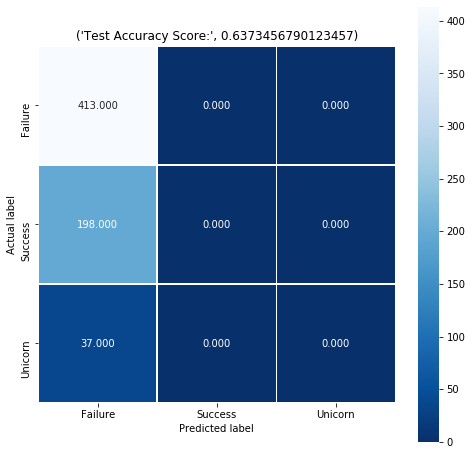

In [847]:
plt.figure(figsize=(8,8))
x_axis_labels = ['Failure', 'Success', 'Unicorn'];
y_axis_labels = ['Failure', 'Success', 'Unicorn'];
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r',xticklabels=x_axis_labels, yticklabels=y_axis_labels);

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
score = 'Test Accuracy Score:',test_score
plt.title(score)

In [911]:
from sklearn.tree import DecisionTreeClassifier

bagging = BaggingClassifier(n_estimators=45,max_features=44,bootstrap_features=True,random_state=14).fit(X_train, Y_train)
pred = bagging.predict(X_test)

train_score = bagging.score(X_train,Y_train)
print("training accuracy: ",train_score)
test_score = bagging.score(X_test,Y_test)
print("testing accuracy: ",test_score)




training accuracy:  0.9253731343283582
testing accuracy:  0.6419753086419753


In [912]:
cm = metrics.confusion_matrix(Y_test, pred)
print(cm)

[[358  52   3]
 [140  53   5]
 [ 23   9   5]]


Text(0.5, 1, "('Test Accuracy Score:', 0.6342592592592593)")

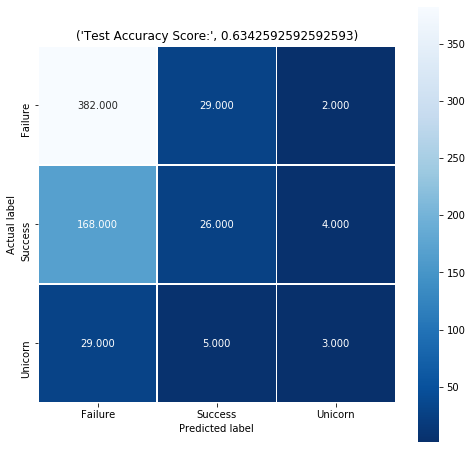

In [866]:
plt.figure(figsize=(8,8))
x_axis_labels = ['Failure', 'Success', 'Unicorn'];
y_axis_labels = ['Failure', 'Success', 'Unicorn'];
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r',xticklabels=x_axis_labels, yticklabels=y_axis_labels);

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
score = 'Test Accuracy Score:',test_score
plt.title(score)

<br>
<br>
<br>
<br>
<br>
### Funding amount by investment round dataframe

In [ ]:
#create df with company id, funding round type, funding round amount, and valuation pre that funding round
dfx = rounds[rounds['object_id'].isin(list(Y['id']))]
dfx = dfx[['object_id','funding_round_code','raised_amount_usd','participants','pre_money_valuation_usd']]
dfx.columns = ['id','funding_round_code','funding_round_amount','participants','pre_money_valuation']
dfx.reset_index(inplace=True, drop=True)

In [ ]:
dfx['funding_round_code'].value_counts()

In [ ]:
#merge predictors with funding rounds and funding per round
Yfm = Yf.merge(dfx,left_on='company_id',right_on='id')
Yfm = Yfm.drop(columns=['valuation','total_funding','funding_rounds','id'])
Yfm = Yfm[['company_id','funding_round_code','most_common_degree_type','most_common_degree_subject','most_common_institution','category','state','participants','pre_money_valuation','funding_round_amount']]
Yfm.columns = ['company_id','funding_round','most_common_degree_type','most_common_degree_subject','most_common_institution','category','state','participants','pre_money_valuation','funding_round_amount']
Yfm

### Split dataframe by funding round to predict funding round amount

In [ ]:
Yfm['funding_round'].value_counts()

In [ ]:
seed = Yfm[Yfm['funding_round_code']=='seed']
seed

### Initial visualization plots

In [ ]:
dfba = dfb['category_code']
clean_dfba = [x for x in dfba if str(x) != 'nan']

plt.hist(clean_dfba)
plt.xticks(rotation='vertical')
plt.title('Company Category')
plt.ylabel('Number of companies'), plt.xlabel('Category')
plt.show()